In [1]:
import numpy as np
import pandas as pd
from numpy import isnan
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats  
from scipy import interp
import seaborn as sns

In [5]:
data = pd.read_csv('my_table_patients_with_norm_measure.csv') 
data_c0 = data[data['motor_status'] == 0]
data_c1 = data[data['motor_status'] == 1]

In [ ]:
print(data_c1.loc[:,"age"].mean())
print(data_c1.loc[:,"age"].std())
print(data_c0.loc[:,"age"].mean())
print(data_c0.loc[:,"age"].std())
print("mean age cohort : ", data.loc[:,"age"].mean())
print("std age cohort : ",data.loc[:,"age"].std())
print("min age cohort : ", data.loc[:,"age"].min())
print("max age cohort : ",data.loc[:,"age"].max())
print("Number of females",len(data.loc[data.gender=="f"])/100)
print("Numebr of males",len(data.loc[data.gender=="m"])/100)
print("Number of patinets with deficits",len(data_c1)/100)
print("Numebr of patients without deficits",len(data_c0)/100)

# Line Plots 

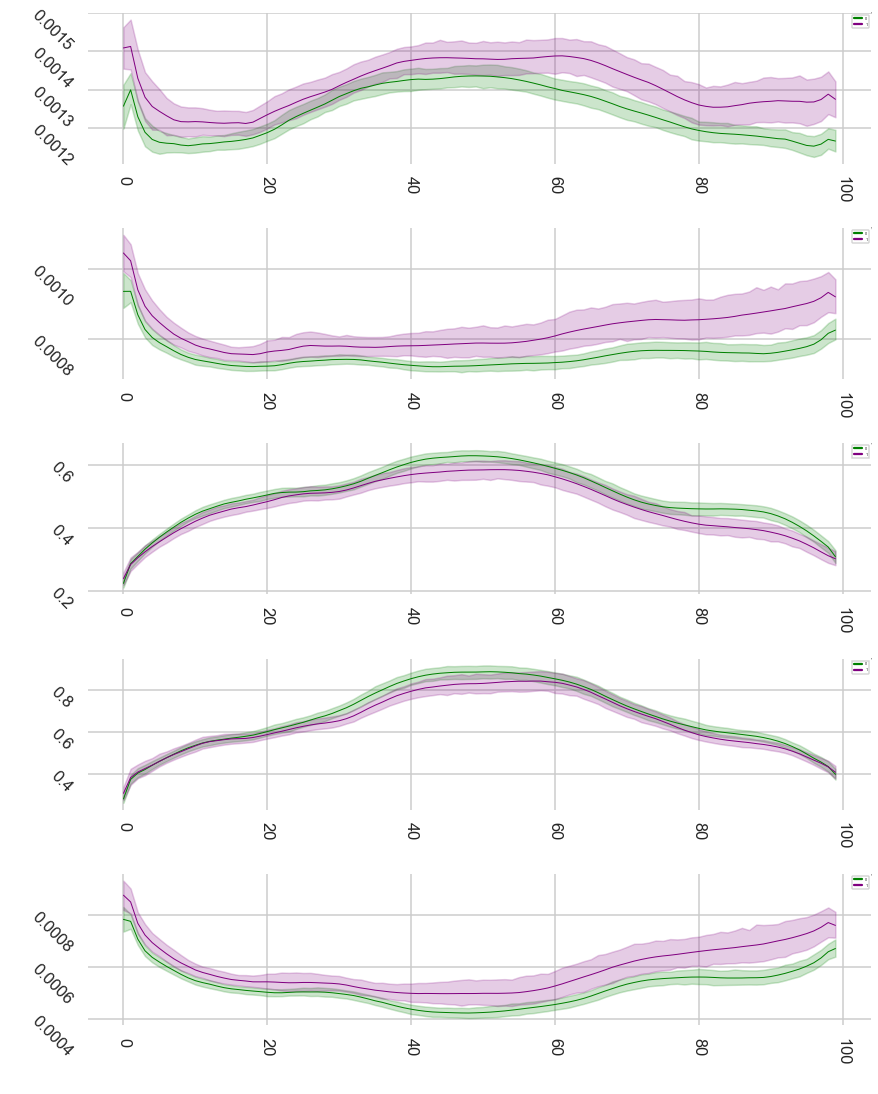

In [22]:
metrics = ['ADP','ADCP','FAP','FDP','RDP']
metric_name = ['AD','ADC','FA','FD','RD']
sns.set(style='whitegrid',palette=['green','purple'])
sns.set_context("talk", font_scale=1) 

fig, axes = plt.subplots(5,figsize=(12,15))
for i, met in enumerate(metrics):
    line_p = sns.lineplot(ax = axes[i],
                          x='loc', 
                          y=(data[met]), 
                          hue='motor_status',
                          data=data, 
                          ci=95, alpha=1, linewidth=1, legend= True)
    axes[i].set_title(metric_name[i],
                      rotation=270, 
                      loc = 'right', 
                      fontweight='bold', 
                      fontsize=1, 
                      pad=0.005)
    axes[i].tick_params(axis='x',labelrotation=270)
    axes[i].tick_params(axis='y',labelrotation=-45)
    axes[i].set_ylabel('   ')  
    axes[i].set_xlabel('   ') 
    axes[i].legend(fontsize=4)

sns.despine(left=True, bottom=True)
fig.tight_layout(pad=0.005)

# t-test 

In [32]:
from statsmodels.stats.multitest import multipletests

gp_data = data.groupby('motor_status')
pvalues_b = dict()
statistics_b = dict() 
for stat_idx, stat in enumerate(metric_name):
        #ax[stat_idx, 0].set_ylabel(stat.upper())
        tract_c0_stat_P = data_c0.pivot(index='loc', columns='Sub_ID', values=stat+'P').T
        tract_c0_stat_H = data_c0.pivot(index='loc', columns='Sub_ID', values=stat+'H').T
        tract_c1_stat_P = data_c1.pivot(index='loc', columns='Sub_ID', values=stat+'P').T
        tract_c1_stat_H = data_c1.pivot(index='loc', columns='Sub_ID', values=stat+'H').T
        statistics_b[stat+'H'], pvalues_b[stat+'H'] = stats.ttest_ind(tract_c0_stat_H, 
                                                                      tract_c1_stat_H, 
                                                                      equal_var = False)
        statistics_b[stat+'P'], pvalues_b[stat+'P'] = stats.ttest_ind(tract_c0_stat_P, 
                                                                      tract_c1_stat_P, 
                                                                      equal_var = False)

# fdr_bh correction and heatmap

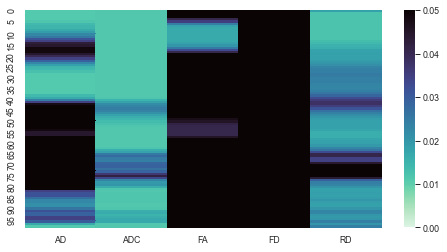

In [98]:
plt.figure(figsize = (8,4))
temp = dict()
b = dict()
for stat_idx, stat in enumerate(metric_name):
    
    #print(stat,multipletests(pvalues_b[stat+'P'], alpha=0.05, method='fdr_bh', 
     #                        is_sorted=False, returnsorted=False))
    _,b[stat],_,_ = multipletests(pvalues_b[stat+'P'], alpha=0.05, method='fdr_bh', 
                                        is_sorted=False, returnsorted=False)
    temp[stat] = np.flip(b[stat])

sns.set_context("paper", font_scale=1)
df = pd.DataFrame(temp)
sns.heatmap(df, annot=False, fmt="g",vmin=0, vmax=0.05, cmap='mako_r')
pd.DataFrame(b).to_csv('alongTract_ttest_correctedpvalues_ipsi.csv')


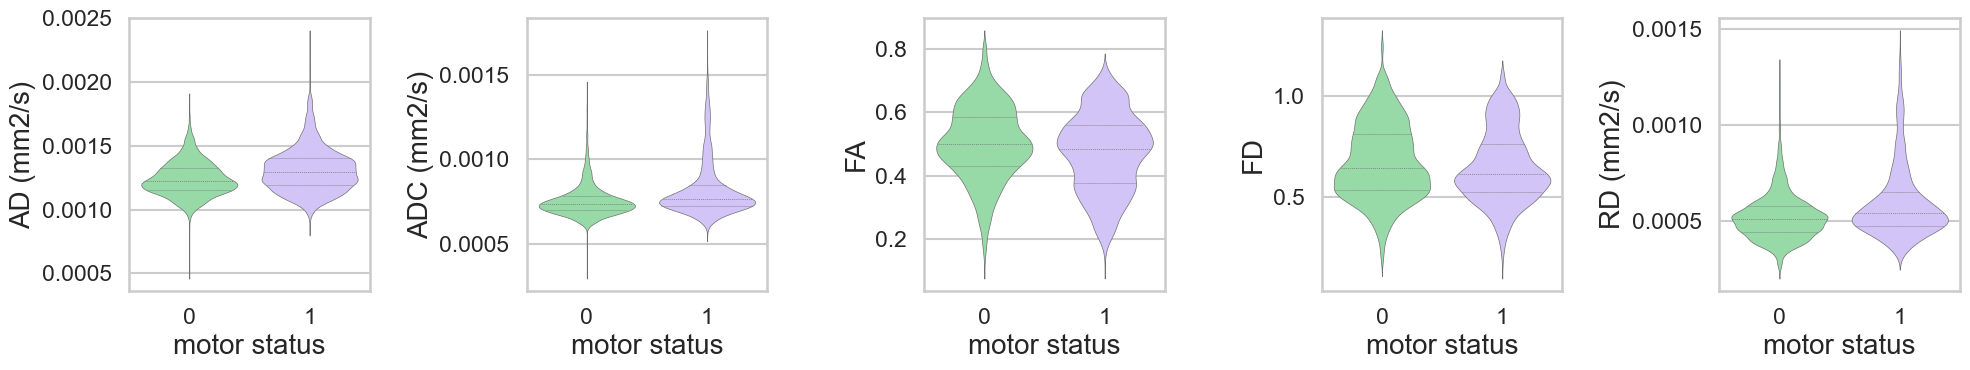

In [16]:
sns.set()
sns.set(style='whitegrid', palette = ["#8DE5A1","#D0BBFF"])
sns.set_context("talk", font_scale=1)
fig, axes = plt.subplots(1,5,figsize=(20,4), dpi=100)
for stat_idx, stat in enumerate(metric_name):
    sns.violinplot(ax=axes[stat_idx], 
                   x='motor_status', 
                   y=data[stat+"P"], 
                   linewidth=0.5, 
                   data=data, fliersize = 2, 
                   ci =95 ,split=True, scale='width', inner="quartile")
    
    if ((stat == "ADC") | (stat == "AD") | (stat=="RD")):
        y_label = stat + " (mm2/s)"
    else:
        y_label = stat
    axes[stat_idx].set_ylabel(y_label, fontsize=20) # fontweight='bold'  
    axes[stat_idx].set_xlabel('motor status',fontsize=20)
    

fig.tight_layout(pad=1)


In [61]:
stats_df = pd.read_csv('my_table_patients_stats_measure.csv') 
stats_df.head()

metrics      Mean  Standard_deviation  Kurtosis  Skewness     MeanH  \
0      AD  0.001378            0.000110 -1.414401 -0.092683  0.001306   
1      AD  0.001338            0.000111  2.295440  1.391494  0.001258   
2      AD  0.001289            0.000083 -0.755139  0.025863  0.001234   
3      AD  0.001244            0.000128  4.899379  1.731534  0.001242   
4      AD  0.001251            0.000135  0.261340  0.070395  0.001278   

       STDH  KurtosisH  SkewnessH  motor_status  Sub_ID  
0  0.000091   2.230042   0.558798             0       1  
1  0.000124  -0.627744   0.413015             1       2  
2  0.000130  -0.920538  -0.006064             1       3  
3  0.000128   5.284320   1.804351             0       4  
4  0.000117  -0.745850  -0.064549             0       5

# Violin plots for statistical features

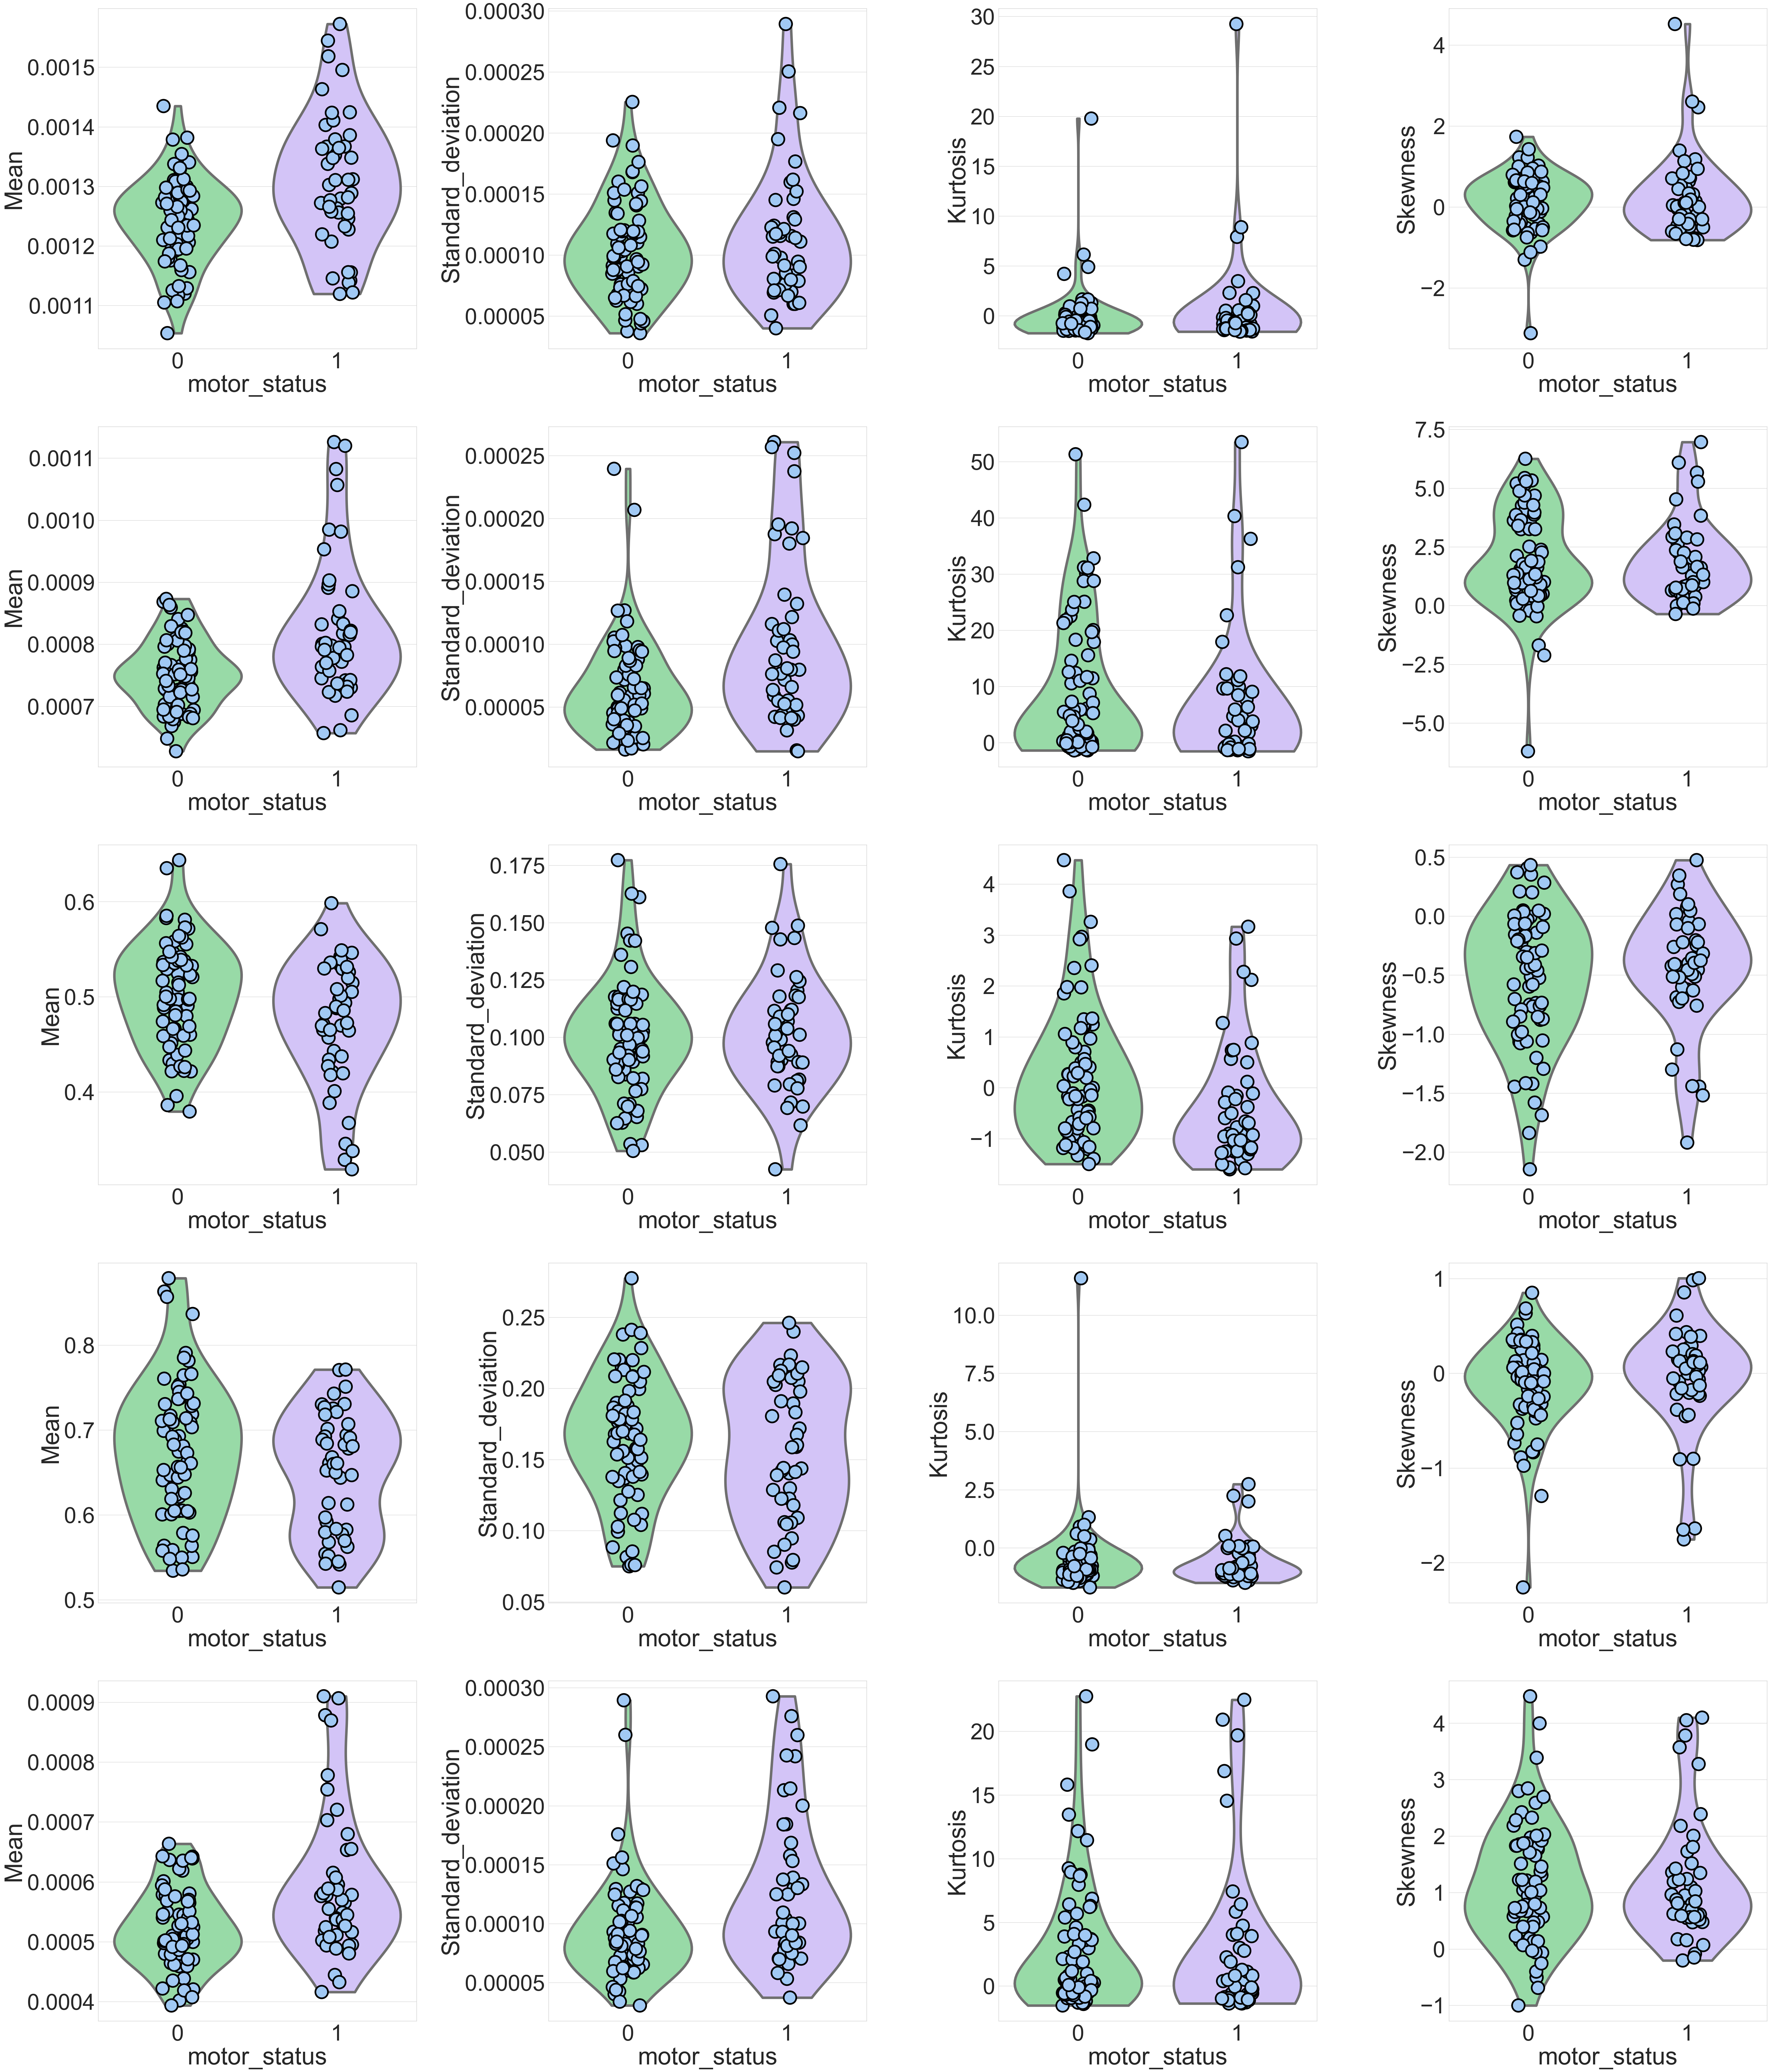

In [234]:
import random
tmp = []
sns.set()
random.seed(123)
sns.set(style='whitegrid') #, palette = ["#8DE5A1","#D0BBFF"]
sns.set_context("paper", font_scale=6) # context='talk'
fig, axes = plt.subplots(5,4,figsize=(60,70), dpi=100) # figsize=(30,36)
for i, met in enumerate(metric_name):
    for j, stat in enumerate(['Mean','Standard_deviation','Kurtosis','Skewness']):
        sns.violinplot(ax = axes[i,j], 
                       x='motor_status', 
                       y=stat, 
                       data=stats_df[stats_df['metrics']==met], 
                       fliersize = 9, scale='width', inner=None, linewidth=6, 
                       palette=["#8DE5A1","#D0BBFF"], cut=0, jitter=True)
        
        sns.stripplot(ax = axes[i,j], x='motor_status', 
                      y=stat, data=stats_df[stats_df['metrics']==met], 
                      jitter=True, linewidth=4, size=30, edgecolor="black", palette=["#A1C9F4"])
        
fig.tight_layout(pad=1)

# MannWhitneyU test and effect size

In [ ]:
import pingouin as pg

save_df = pd.DataFrame(columns=['metrics','Mean_ipsilesional','Standard_deviation_ipsilesional',
                                    'Kurtosis_ipsilesional','Skewness_ipsilesional','Mean_contralesional',
                                        'STD_contralesional','Kurtosis_contralesional','Skewness_contralesional','test'])
static = np.zeros(shape=(5,4))
pvalue = np.zeros(shape=(5,4))
for i, met in enumerate(metric_name):
    for j, stat in enumerate(['Mean','Standard_deviation','Kurtosis','Skewness']):
        df = stats_df[stats_df['metrics']==met]
        u , p = stats.mannwhitneyu(df[df['motor_status']==0].loc[:,stat],df[df['motor_status']==1].loc[:,stat]) 
        static[i,j], pvalue[i,j] = stats.mannwhitneyu(df[df['motor_status']==0].loc[:,stat],df[df['motor_status']==1].loc[:,stat])
        print(met,',',stat,':\n')
        print('U:',u,'P:',p)
        r = 1-(2*u)/(df[df['motor_status']==0].loc[:,stat].shape[0]*df[df['motor_status']==1].loc[:,stat].shape[0])
        print('r:',r,'\n')
   

# Kernel Density Estimation for along tract metrics

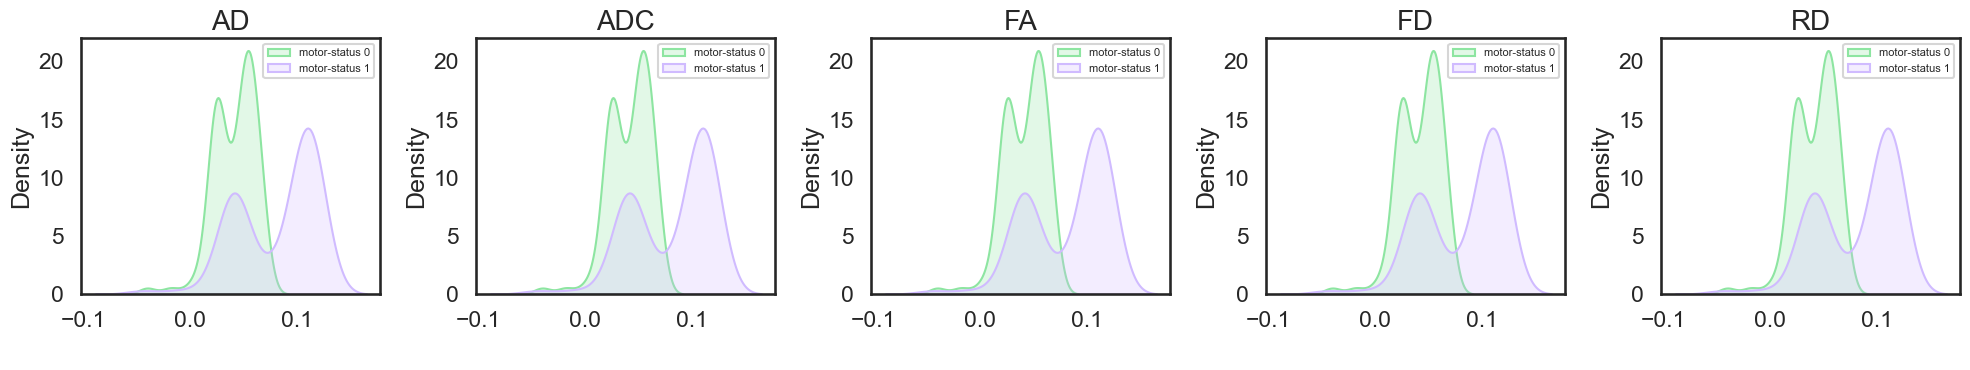

In [230]:
sns.set()
sns.set(style='white', palette = ["#8DE5A1","#D0BBFF"]) # "#8DE5A1","#D0BBFF"
sns.set_context("talk", font_scale=1)
fig, axes = plt.subplots(1,5,figsize=(20,4), dpi=100)
for i, met in enumerate(metric_name):
    sns.kdeplot(data_c0.groupby("loc")[j+'_norm'].mean(), 
                fill=True, label='motor-status 0',ax=axes[i])
    sns.kdeplot(data_c1.groupby("loc")[j+'_norm'].mean(), fill=True, label='motor-status 1',ax=axes[i])
    axes[i].set_xlabel(' ')
    axes[i].set_title(met, fontsize=20)
    axes[i].legend(loc='upper right',fontsize=8)

fig.tight_layout(pad=1)

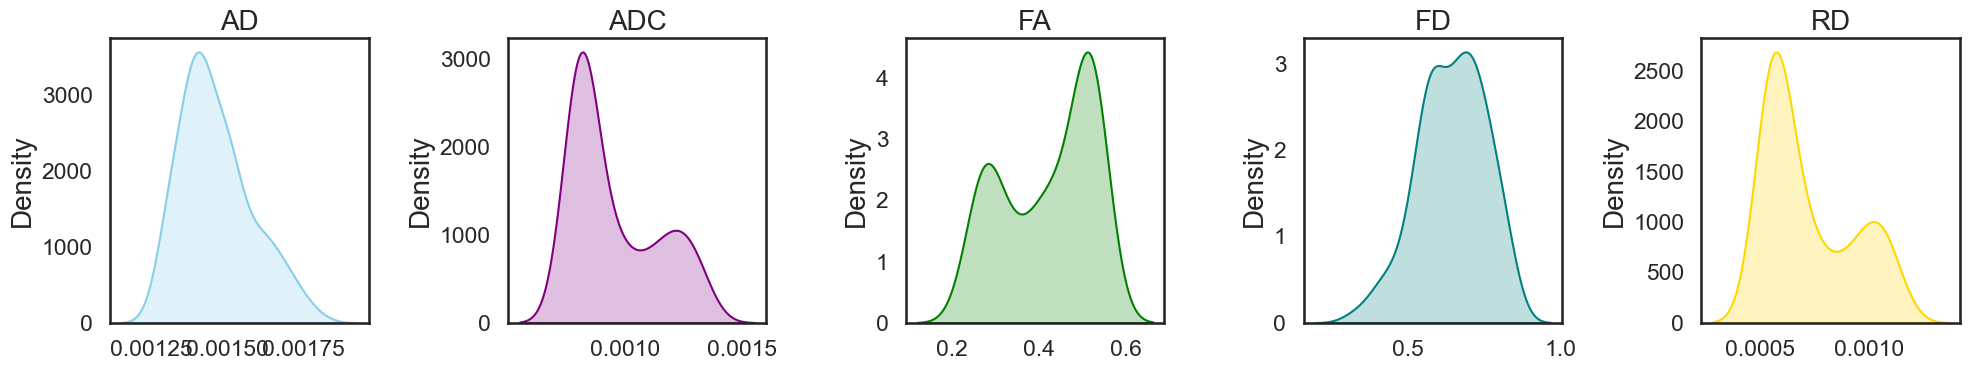

In [232]:
import seaborn as sns
data = pd.read_csv('my_table_patients_with_norm_measure.csv') 
# Patient's ID
n=8
data_tmp = data.loc[data.Sub_ID==8, ['ADP','ADCP','FAP','FDP','RDP']] # patient's ID=8 was included in the manuscript (18, 22, 26,81, 124,130, 149,159, 164, 208, 344, 371, 405)   
sns.set()
sns.set(style='white') 
sns.set_context("talk", font_scale=1)
fig, axes = plt.subplots(1,5,figsize=(20,4), dpi=100)
for i, j in enumerate(metric_name):
    color = ['skyblue','purple', 'green', 'teal', 'gold']
    sns.kdeplot(data_tmp.iloc[:,i], fill=True, ax=axes[i], color=color[i])    
    axes[i].set_title(j, fontsize=20)
    axes[i].set_ylabel('Density',fontsize=20)
    axes[i].set_xlabel('')
fig.tight_layout(pad=1)

#print(data_tmp.iloc[:,i].mean())
#print(data_tmp.iloc[:,i].std())
#print(data_tmp.iloc[:,i].skew())
#print(data_tmp.iloc[:,i].kurt())

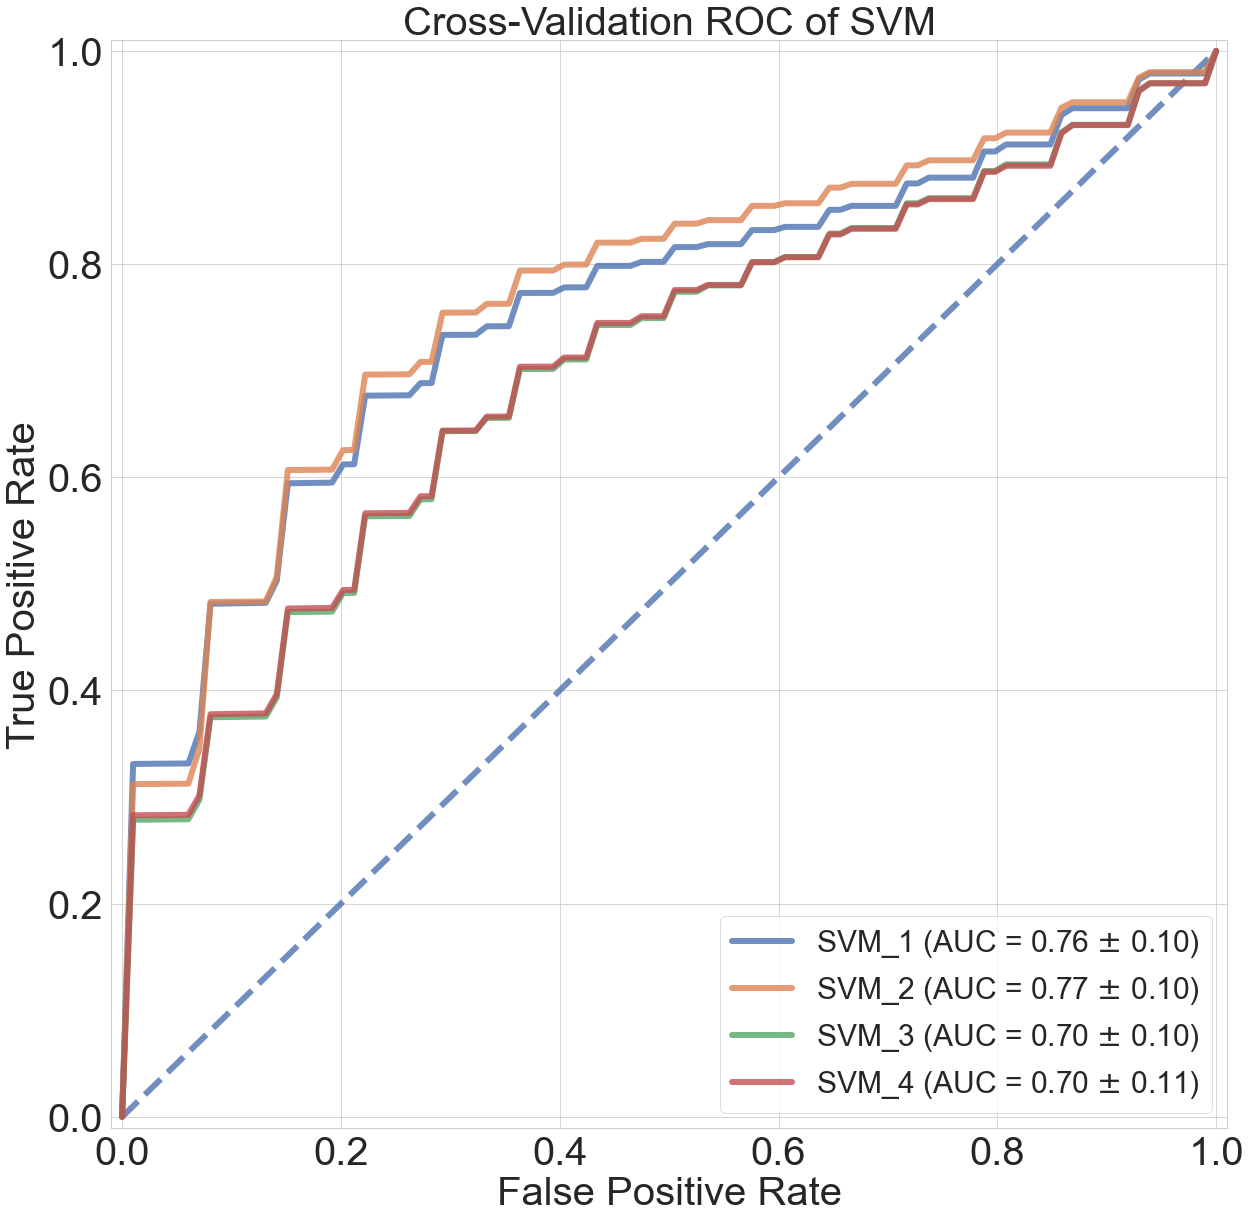

In [18]:
from numpy import savetxt, loadtxt
import matplotlib.pyplot as plt

# according to the SVM model in the manuscript SVM1-4 are based on median profile
# add also SVM_5

list_tpr = ['mean_tpr_Mdn_MdnImp','mean_tpr_Mdn_knn20Imp','mean_tpr_M_MdnImp','mean_tpr_M_knn20Imp','mean_tpr_demo']
list_fpr = ['mean_fpr_Mdn_MdnImp','mean_fpr_Mdn_knn20Imp','mean_fpr_M_MdnImp','mean_fpr_M_knn20Imp','mean_fpr_demo']
list_auc = ['mean_auc_Mdn_MdnImp','mean_auc_Mdn_knn20Imp','mean_auc_M_MdnImp','mean_auc_M_knn20Imp','mean_auc_demo']
list_std = ['std_Mdn_MdnImp','std_Mdn_knn20Imp', 'std_M_MdnImp','std_M_knn20Imp','std_demo']
legend_ = ['SVM_1','SVM_2','SVM_3','SVM_4', 'SVM_6'] 

plt.figure(figsize=(20,20))
plt.plot([0,1],[0,1],linestyle = '--',lw = 6,color = 'b',alpha=0.8)

for i in range(4):
    mean_tpr = loadtxt('/Users/boshra/Desktop/Boshra/'+list_tpr[i]+'.csv', delimiter=',')
    mean_fpr = loadtxt('/Users/boshra/Desktop/Boshra/'+list_fpr[i]+'.csv', delimiter=',')
    mean_auc = loadtxt('/Users/boshra/Desktop/Boshra/'+list_auc[i]+'.csv', delimiter=',')
    std = loadtxt('/Users/boshra/Desktop/Boshra/'+list_std[i]+'.csv', delimiter=',')
    
    plt.plot(mean_fpr, mean_tpr,
            label= legend_[i]+r' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std),lw=6, alpha=0.8)


#std_tpr = np.std(tprs, axis=0)
plt.xlabel('False Positive Rate',fontsize = 40)
plt.ylabel('True Positive Rate',fontsize = 40)
plt.title('Cross-Validation ROC of SVM',fontsize = 40)
plt.legend(loc="lower right", prop={'size': 30})
plt.xlim([-0.01, 1.01]) 
plt.ylim([-0.01, 1.01]) 

plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 4
plt.show()